### Setting up the stage!

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib import pyplot as plt

### User Input Required!

In [2]:
# Add the csv file name and location here!
# Get the file under DCA Bot > My Deals > Deals History > Export
source = "data/3commas-dca-deals-2021-01-01-2021-01-07.csv"

### Other variables

In [3]:
# Creates empty dataframe
summary = pd.DataFrame()
summary.index.name = "Bot ID"
bots = pd.DataFrame()
bots.index.name = "Bot ID" 

#TODO REVIEW ALL STATUSES
trade_status_closed = ["completed", "stop_loss_finished"]
trade_status_wins = ["completed"]
trade_status_losses = ["stop_loss_finished"]
trade_status_active = ["bought"] 

In [4]:
# those_columns = ["close_date", "bot", "final_profit", "loss", "win", "used_safety_orders", "pair"]
# bot_settings = ["take_profit_condition", "base_order_volume", "safety_order_volume"]

result_columns = ["win", "loss", "final_profit"]
those_columns = ["close_date", "bot", "final_profit", "loss", "win", "used_safety_orders", 
                 "pair", "take_profit_condition", "base_order_volume", "safety_order_volume"]

### Grabbing the data

In [5]:
data = pd.read_csv(source,
                   sep=";",
                   index_col="deal_id",
                   header=0,
                   parse_dates=['closed_at'])

In [6]:
# Sorting per close_date
data = data.sort_values(by='close_date',ascending=True)

### TO-DO!

**IMPORTANT!** Must make a distinction between profit in base and quote! 🙀 

### Raise an error if there's more than one base

In [7]:
# Check if the base asset is the same in all pairs 
base_pair = data["pair"].str.split("_").str[0].unique()
if len(base_pair) == 1:
    base_pair = base_pair[0]
else:
    raise("ERROR! 🙀 More than one base, not prepared for that!")

### Filtering the data

In [8]:
# Data range
# Comment all to get the entire data

# Slicing per date range
# data = data[(data["close_date"] >= "2021-01-01") &
#            (data["close_date"] <= "2021-01-04")]

# Only after/before/equal a certain date
# data = data[(data["close_date"] == "2021-01-07")]

In [9]:
# ONLY this(these) bot(s)!
# data = data[data["bot"] == "RSI7 < 30 3m"]

In [10]:
# REMOVE these bots!
# bots_remove = ["Gordon-LEV-Conservative", "Gordon-LEV-Moderate", 
#                "Gordon-Conservative", "Gordon-Agressive"]
# data = data[~data["bot"].isin(bots_remove)]

### Replace NANs from "final_profit" feature withzeros

In [11]:
data['final_profit'] = data['final_profit'].fillna(0)

### Add features

In [12]:
# Add "win" feature with the sum of positive profits of the day
data["win"] = np.where(data["final_profit"] >0, data["final_profit"], 0)
# Add 'loss' column with the sum of negative profits of the day as a ABS number
data["loss"] = np.where(data["final_profit"] <0, data["final_profit"], 0)
data["loss"] = data["loss"].abs()

In [13]:
# Add "cum_profit" feature
# data["cum_profit"] = data["final_profit"].cumsum()

### Generate Report

**IMPORTANT!** Whenever we have mean() with rows with zero value, math might be wrong!

In [14]:
for bot_id in data["bot_id"].unique():
    trades_total = len(data[(data["bot_id"] == bot_id)])
    trades_closed = len(data[(data["bot_id"] == bot_id) & (data["status"].isin(trade_status_closed))])
    trades_win = len(data[(data["bot_id"] == bot_id) & (data["status"].isin(trade_status_wins))])*100 / trades_closed
    trades_win = round(trades_win, 2)
    trades_losses = len(data[(data["bot_id"] == bot_id) & (data["status"].isin(trade_status_losses))])*100 / trades_closed
    trades_losses = round(trades_losses, 2)
    trades_duration_avg = data[data["bot_id"] == bot_id]["duration"].mean()
    trades_duration_avg = pd.to_datetime(trades_duration_avg, unit="s")
    trades_so_avg = data[data["bot_id"] == bot_id]["used_safety_orders"].mean()
    trades_so_max = data[data["bot_id"] == bot_id]["max_safety_orders_count"].iloc[0] 
    #TODO: NOT WORKING!
    trades_so_max_avg = len(data[(data["bot"] == bot_id) & 
                                 (data["used_safety_orders"] == data["max_safety_orders_count"].max())])
    trades_so_max_avg = (trades_so_max_avg *100)/trades_closed
    
    # Add data to Summary dataframe
    summary.loc[bot_id, "Bot Name"] = data[data["bot_id"] == bot_id]["bot"].unique()
    summary.loc[bot_id, "AVG Profit (%)"] = round(data[(data["bot_id"] == bot_id)]["profit_percentage_from_total_volume"].mean(),2)
    profit_column_name = f"Profit ({base_pair})"
    summary.loc[bot_id, profit_column_name] = data[(data["bot_id"] == bot_id) & (~data["status"].isin(trade_status_active))]["final_profit"].sum()
    summary.loc[bot_id, "Win (%)"] = trades_win
    summary.loc[bot_id, "Loss (%)"] = trades_losses
    summary.loc[bot_id, "Closed Trades"] = trades_closed
    summary.loc[bot_id, "AVG Trade Duration"] = trades_duration_avg
    summary.loc[bot_id, "Max SO Set"] = trades_so_max
    #TODO: NOT WORKING!
    summary.loc[bot_id, "Max SO Used (%)"] = trades_so_max_avg
    summary.loc[bot_id, "AVG SO/Trade"] = trades_so_avg
    # TODO: AVG DEALS PER DAY/TIME THE BOT HAS BEEN ACTIVE // REQUIRES INFO IN THE SOURCE DATA

summary["Closed Trades"] = summary["Closed Trades"].astype(int) 
summary["AVG Trade Duration"] = summary["AVG Trade Duration"].dt.strftime("%H:%M:%S")
summary

,Bot Name,AVG Profit (%),Profit (USDT),Win (%),Loss (%),Closed Trades,AVG Trade Duration,Max SO Set,Max SO Used (%),AVG SO/Trade
Bot ID,,,,,,,,,,
2145925,Gordon-Moderate,2.41,252.820021,100.00,0.00,36,03:30:07,3.0,0.0,0.666667
2281779,TBT Signals,1.60,71.135138,100.00,0.00,17,03:46:44,2.0,0.0,0.764706
2292725,RSI7 < 30 3m,0.74,27.988115,88.89,11.11,90,01:14:46,2.0,0.0,0.670330
2297369,Gordon-Moderate-TP1.5-SL8,1.71,22.648991,100.00,0.00,7,01:07:59,3.0,0.0,0.142857
2313262,RSI7 < 30 3m OTHER COINS,-0.04,-26.426922,68.42,31.58,19,01:49:35,1.0,0.0,0.421053
2314379,RSI7 < 30 3m BTC ETH BNB ACCUM,2.53,22.520468,100.00,0.00,7,02:06:12,1.0,0.0,0.285714


In [15]:
closed_trades = len(data[data["status"].isin(trade_status_closed)])
total_profit = data["final_profit"].sum()
print(f"Total number of closed trades: {closed_trades}")
print(f"Total profit: ${total_profit}")

Total number of closed trades: 176
Total profit: $370.68581163000005


### Paintbrush

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/pandas/plotting/_matplotlib/core.py:1192: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


Text(0.5, 1.0, '3Commas DCA Bots')

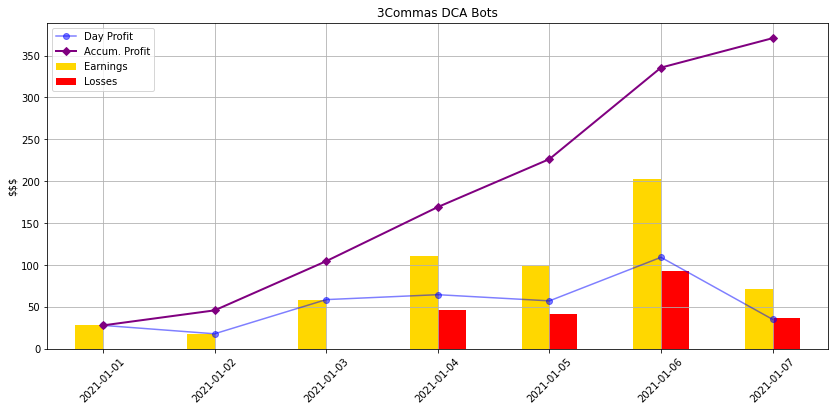

In [16]:
ax = data.groupby("close_date")["final_profit"].sum().plot(marker="o",
                                                           stacked=False,
                                                           color="blue",
                                                           alpha=0.5)
data.groupby("close_date")["final_profit"].sum().cumsum().plot(ax=ax, 
                                                               marker='D',
                                                               lw=2,
                                                               color="purple")
data.groupby("close_date")[["win", "loss"]].sum().plot(ax=ax,
                                                       kind="bar",
                                                       figsize=(14,6),
                                                       grid=True,
                                                       color=["gold", "r"],
                                                       rot=45,
                                                       label='Day Profit')

ax.legend(["Day Profit", "Accum. Profit", "Earnings", "Losses"])
ax.set_xlabel("")
ax.set_ylabel("$$$")
plt.title("3Commas DCA Bots")

Text(0.5, 1.0, '3Commas DCA Bots')

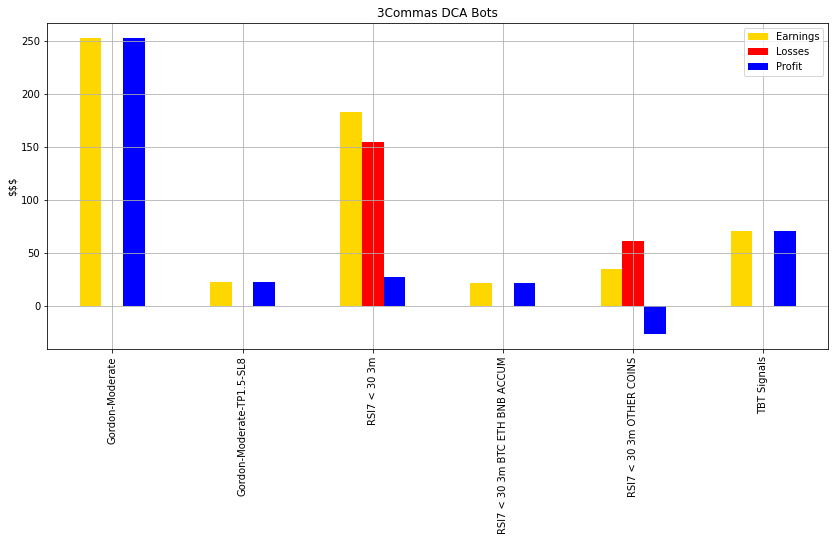

In [17]:
ax = data.groupby("bot")[result_columns].sum().plot(kind="bar",
                                                    figsize=(14,6),
                                                    grid=True,
                                                    color=["gold", "red", "blue"],
                                                    rot=90)

ax.legend(["Earnings", "Losses", "Profit"])
ax.set_xlabel("")
ax.set_ylabel("$$$")
plt.title("3Commas DCA Bots")

### Bots Settings (Most Recent Settings)

In [18]:
for bot_id in data["bot_id"].unique():
    bots.loc[bot_id, "bot"] = data[(data["bot_id"] == bot_id)]["bot"].unique()
    bots.loc[bot_id, "TP"] = data[(data["bot_id"] == bot_id)]["take_profit_condition"].iloc[-1]
    bots.loc[bot_id, "SO Count"] = data[(data["bot_id"] == bot_id)]["max_safety_orders_count"].iloc[-1]
    bots.loc[bot_id, "SO%"] = data[(data["bot_id"] == bot_id)]["safety_order_step_percentage"].iloc[-1]
    bots.loc[bot_id, "SO Vol"] = data[(data["bot_id"] == bot_id)]["safety_order_volume"].iloc[-1]

bots

,bot,TP,SO Count,SO%,SO Vol
Bot ID,,,,,
2145925,Gordon-Moderate,2.50,3.0,2.5,200.0
2281779,TBT Signals,1.50,2.0,1.5,210.0
2292725,RSI7 < 30 3m,1.90,2.0,1.5,150.0
2297369,Gordon-Moderate-TP1.5-SL8,1.50,3.0,2.0,200.0
2313262,RSI7 < 30 3m OTHER COINS,1.88,1.0,2.0,100.0
2314379,RSI7 < 30 3m BTC ETH BNB ACCUM,2.50,1.0,2.0,100.0


Text(0, 0.5, '$$$')

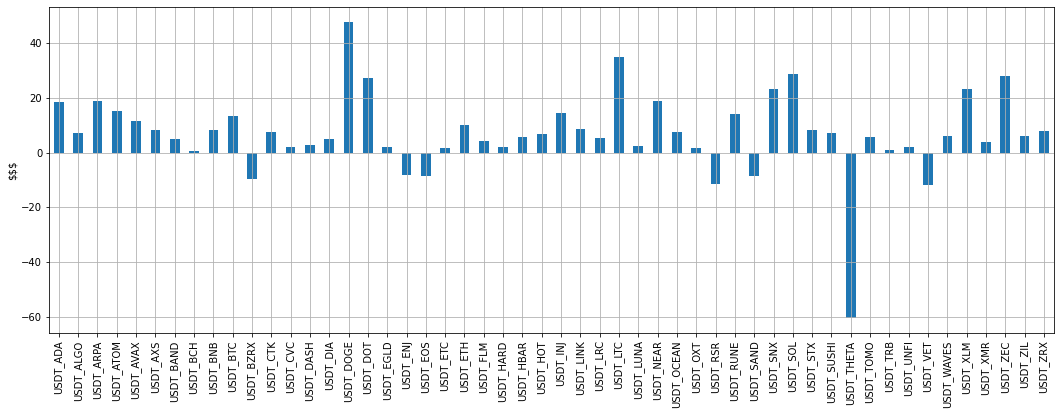

In [19]:
ax = data.groupby("pair")["final_profit"].sum().plot(kind="bar", 
                                                     figsize=(18,6),
                                                     grid=True)
ax.set_xlabel("")
ax.set_ylabel("$$$")